# Sandbox for training a classifier on patient features to help enusre that feature extraction is working

In [1]:
# Libraries
import numpy as np
import scipy.io as sio
import os
# import pickle
# import ieeg_funcs as ief
# import re
import dgFuncs as dg
from sklearn import preprocessing
# from scipy import stats
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import svm, linear_model
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline


In [44]:
import imp 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [13]:
# Get size of szr data 
in_file='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/1096_szr_sample_size.mat'
n_szr_dict=sio.loadmat(in_file)
print(n_szr_dict.keys())
print(n_szr_dict['n_tpt_ct'])
n_szr_wind=0
for temp_n in n_szr_dict['n_tpt_ct']:
    n_szr_wind+=temp_n
print('%d total # of szr time windows' % n_szr_wind)

dict_keys(['__version__', '__globals__', 'n_tpt_ct', 'soz_chans_bi', '__header__', 'ftr_fs'])
[[ 3687]
 [ 5922]
 [11196]
 [11196]
 [ 4947]
 [ 4947]
 [ 3701]
 [ 3701]
 [ 1208]]
50505 total # of szr time windows


In [16]:
# Get size of non-szr data (and filename)
# Get filenames 
#/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096_HL1_HL2_non.mat
ftr_path='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
non_fnames=list()
szr_fnames=list()
for f in os.listdir(ftr_path):
    if f.endswith('non.mat'):
        non_fnames.append(f)
    elif f.endswith('.mat') and f.startswith('1096_'):
        szr_fnames.append(f)
        
print('%d non-szr files found',len(non_fnames))
print('%d szr files found',len(szr_fnames))  
    
# Loop over NON-szr files to get total # of windows
n_non_wind=0
ftr_dim=0
for f in non_fnames:
    in_file=os.path.join(ftr_path,f)
    temp_ftrs=sio.loadmat(in_file)
    n_non_wind+=temp_ftrs['nonszr_se_ftrs'].shape[1]
    if ftr_dim==0:
        ftr_dim=temp_ftrs['nonszr_se_ftrs'].shape[0]

print('%d total # of NON-szr time windows' % n_non_wind)

# Loop over SZR files to get total # of windows
n_szr_wind=0
for f in szr_fnames:
    in_file=os.path.join(ftr_path,f)
    temp_ftrs=sio.loadmat(in_file)
    n_szr_wind+=temp_ftrs['se_ftrs'].shape[1]

print('%d total # of SZR time windows' % n_szr_wind)
# print(temp_ftrs.keys())

%d non-szr files found 8
%d szr files found 41
49665 total # of NON-szr time windows
50505 total # of SZR time windows


In [51]:
print(in_file)
just_fname=in_file.split('/')[-1]
print(just_fname)
jf_splt=just_fname.split('_')
chan_label=jf_splt[1]+'-'+jf_splt[2]
print(chan_label)

/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096_HL8_HL9_non.mat
1096_HL8_HL9_non.mat
HL8-HL9


In [52]:
def chan_labels_from_fname(in_file):
#     print(in_file)
    just_fname=in_file.split('/')[-1]
#     print(just_fname)
    jf_splt=just_fname.split('_')
    chan_label=jf_splt[1]+'-'+jf_splt[2]
    return chan_label

In [62]:
# Preallocate memory
ftrs=np.zeros((ftr_dim,n_szr_wind+n_non_wind))
targ_labels=np.zeros(n_szr_wind+n_non_wind)

# Import non-szr data
ptr=0
mns_dict=dict()
sds_dict=dict()
for f in non_fnames:
    in_file=os.path.join(ftr_path,f)
    chan_label=chan_labels_from_fname(in_file)
    
    temp_ftrs=sio.loadmat(in_file)
    temp_n_wind=temp_ftrs['nonszr_se_ftrs'].shape[1]
    raw_ftrs=temp_ftrs['nonszr_se_ftrs']
    temp_mns, temp_sds=dg.trimmed_normalize(raw_ftrs,0)
    mns_dict[chan_label]=temp_mns
    sds_dict[chan_label]=temp_sds
    
    ftrs[:,ptr:ptr+temp_n_wind]=raw_ftrs
    targ_labels[ptr:ptr+temp_n_wind]=0
    ptr+=temp_n_wind

# Import szr data
for f in szr_fnames:
    in_file=os.path.join(ftr_path,f)
    chan_label=chan_labels_from_fname(in_file)
    if chan_label=='HL9-HL10':
        chan_label='HL8-HL9' #Hack as I still need to compute non-szr ftrs for this pair
            
    temp_ftrs=sio.loadmat(in_file)
    temp_n_wind=temp_ftrs['se_ftrs'].shape[1]
    raw_ftrs=temp_ftrs['se_ftrs']
    dg.applyNormalize(raw_ftrs,mns_dict[chan_label],sds_dict[chan_label])
        
    ftrs[:,ptr:ptr+temp_n_wind]=raw_ftrs
    targ_labels[ptr:ptr+temp_n_wind]=1;
    ptr+=temp_n_wind


30 dimensions
3795 observations
30 dimensions
5940 observations
30 dimensions
11220 observations
30 dimensions
11220 observations
30 dimensions
4950 observations
30 dimensions
4950 observations
30 dimensions
3795 observations
30 dimensions
3795 observations


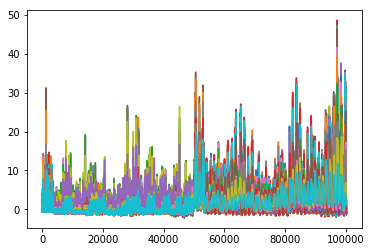

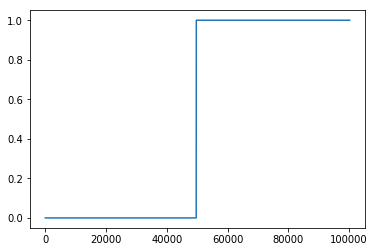

In [63]:
plt.figure(1)
plt.clf()
plt.plot(ftrs.T);

plt.figure(2)
plt.clf()
plt.plot(targ_labels);

In [76]:
# Train classifier
C=1
model = linear_model.LogisticRegression(C=C,class_weight='balanced')

model.fit(ftrs.T, targ_labels)

# 

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [77]:
train_class_hat = model.predict_proba(ftrs.T)[:,1]

In [79]:
from sklearn.metrics import roc_auc_score
auc=roc_auc_score(targ_labels, train_class_hat)
print('AUC=%.3f' % auc)

AUC=0.930


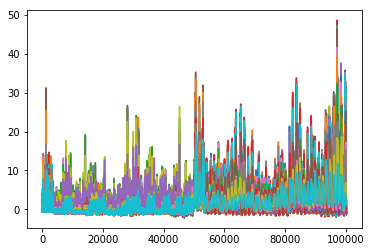

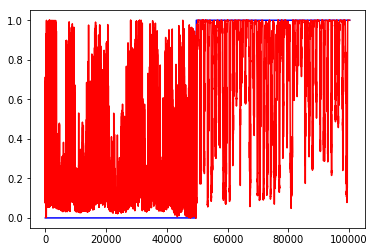

In [78]:
plt.figure(11)
plt.clf()
plt.plot(ftrs.T);

plt.figure(12)
plt.clf()
plt.plot(targ_labels,'b-');
plt.plot(train_class_hat,'r-');

In [15]:
print(temp_ftrs.keys())

dict_keys(['se_time_sec', '__version__', 'ftr_labels', 'szr_fname', 'se_szr_class', 'se_ftrs', '__globals__', '__header__'])


In [11]:
temp_ftrs['nonszr_se_ftrs'].shape[1]

3795

In [32]:
ftrs.shape

(30, 100170)

In [31]:
ftrs.shape

(30, 100170)

In [ ]:
# Train classifier


In [ ]:
# Predict data

In [ ]:
# Plot some szrs along with predictions?